In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import os


Using TensorFlow backend.


In [2]:
def load_split(basePath, csvPath):
    # initialize the list of data and labels
    data = []
    labels = []

    rows = open(csvPath).read().strip().split("\n")[1:]
    random.shuffle(rows)

    # loop over the rows of the CSV file
    for (i, row) in enumerate(rows):
        # check to see if we should show a status update
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {} total images".format(i))

        # split the row into components and then grab the class ID
        # and image path
        (label, imagePath) = row.strip().split(",")[-2:]

        # derive the full path to the image file and load it
        imagePath =  basePath + imagePath
        image = io.imread(imagePath)

        # resize the image to be 32x32 pixels, ignoring aspect ratio,
        # and then perform Contrast Limited Adaptive Histogram
        # Equalization (CLAHE)
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)

        # update the list of data and labels, respectively
        data.append(image)
        labels.append(int(label))

    # convert the data and labels to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    # return a tuple of the data and labels
    return (data, labels)

In [6]:
# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

In [7]:
# derive the path to the training and testing CSV files
trainPath = "dataset/Train.csv"
testPath = "dataset/Test.csv"

In [8]:
# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split("dataset/", trainPath)
(testX, testY) = load_split("dataset/", testPath)

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total 

In [9]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [10]:
# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

In [41]:
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [11]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

In [19]:
# initialize the number of epochs to train for, base learning rate,
# and batch size
epoch = 30
lr = 1e-3
batch_size = 64

In [23]:
from keras.models import Sequential
from keras.layers import *
def build_model(width, height, depth, classes):
	# initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = Sequential()
	inputShape = (height, width, depth)
	chanDim = -1

	# CONV => RELU => BN => POOL
	model.add(Conv2D(8, (5, 5), padding="same",
		input_shape=inputShape))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
	model.add(Conv2D(16, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(16, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
	model.add(Conv2D(32, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(32, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# first set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(128))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))

	# second set of FC => RELU layers
	#model.add(Flatten())
	model.add(Dense(128))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))

	# softmax classifier
	model.add(Dense(classes))
	model.add(Activation("softmax"))

	# return the constructed network architecture
	return model

## Define Model

In [24]:
model = build_model(width=32, height=32, depth=3,classes=numLabels)
opt = Adam(lr=lr, decay=lr / (epoch * 0.5))
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [42]:
# compile the model and train the network
# print("[INFO] training network...")
from keras.callbacks import EarlyStopping

H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=batch_size),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // batch_size,
    epochs=epoch,
    class_weight=classWeight,
    callbacks=[early_stopping_monitor],
    verbose=1)

Epoch 1/30
612/612 [==============================] - 60s 98ms/step - loss: 2.6888 - accuracy: 0.2904 - val_loss: 3.0429 - val_accuracy: 0.2186
Epoch 2/30
612/612 [==============================] - 56s 92ms/step - loss: 1.3333 - accuracy: 0.5790 - val_loss: 0.7640 - val_accuracy: 0.7472
Epoch 3/30
612/612 [==============================] - 56s 91ms/step - loss: 0.8438 - accuracy: 0.7278 - val_loss: 0.4514 - val_accuracy: 0.8490
Epoch 4/30
612/612 [==============================] - 57s 93ms/step - loss: 0.6353 - accuracy: 0.7946 - val_loss: 0.4833 - val_accuracy: 0.8394
Epoch 5/30
612/612 [==============================] - 59s 96ms/step - loss: 0.5068 - accuracy: 0.8372 - val_loss: 0.3275 - val_accuracy: 0.8930
Epoch 6/30
612/612 [==============================] - 58s 94ms/step - loss: 0.4581 - accuracy: 0.8515 - val_loss: 0.3905 - val_accuracy: 0.8746
Epoch 7/30
612/612 [==============================] - 58s 94ms/step - loss: 0.3896 - accuracy: 0.8745 - val_loss: 0.2944 - val_accuracy:

In [59]:
predictions = model.predict(testX)

In [64]:
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.03      0.73      0.06        60
                              Speed limit (30km/h)       0.33      0.65      0.44       720
                              Speed limit (50km/h)       0.75      0.01      0.02       750
                              Speed limit (60km/h)       0.00      0.00      0.00       450
                              Speed limit (70km/h)       0.00      0.00      0.00       660
                              Speed limit (80km/h)       0.42      0.01      0.02       630
                       End of speed limit (80km/h)       0.00      0.00      0.00       150
                             Speed limit (100km/h)       0.97      0.07      0.14       450
                             Speed limit (120km/h)       0.55      0.10      0.17       450
                                        No passing       0.81      0.07      0.

In [65]:
model.save("model/model.h5")

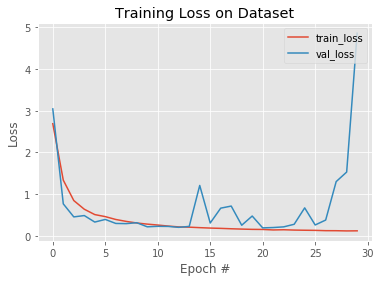

In [72]:
# plot the training loss and accuracy
N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("output/plot.png")

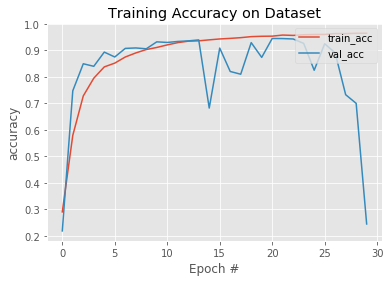

In [71]:
# plot the training loss and accuracy
N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend(loc="upper right")
plt.savefig("output/plot.png")